In [73]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, KFold
from sklearn.metrics import accuracy_score, mean_squared_error, roc_curve, auc, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

In [75]:
import zipfile

# Defining the paths for the training and testing data
train_path = '/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip'
test_path = '/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip'

# Extracting the training and testing data from the ZIP files
with zipfile.ZipFile(train_path, 'r') as train_zip:
    train_zip.extractall('../data')
    
with zipfile.ZipFile(test_path, 'r') as test_zip:
    test_zip.extractall('../data')

In [76]:
train_jpg_names = os.listdir('../data/train')

label = []

for k in train_jpg_names:
    if 'cat' in k:
        label.append('Cat')
    elif 'dog' in k:
        label.append('Dog')
    else:
        label.append('Unknown')

In [77]:
train_data = pd.DataFrame({'Filename':train_jpg_names, 'Label':label})

In [78]:
test_jpg_names = os.listdir('../data/test')

test_data = pd.DataFrame({'Filename':test_jpg_names})

In [79]:
train_data.head(10)

,Filename,Label
0,dog.890.jpg,Dog
1,dog.1178.jpg,Dog
2,dog.7845.jpg,Dog
3,dog.4632.jpg,Dog
4,cat.3660.jpg,Cat
5,dog.814.jpg,Dog
6,dog.2066.jpg,Dog
7,dog.8575.jpg,Dog
8,dog.1444.jpg,Dog
9,cat.9803.jpg,Cat


In [80]:
test_data.head(10)

,Filename
0,10435.jpg
1,6790.jpg
2,4644.jpg
3,1835.jpg
4,1102.jpg
5,8962.jpg
6,6040.jpg
7,4423.jpg
8,12072.jpg
9,1806.jpg


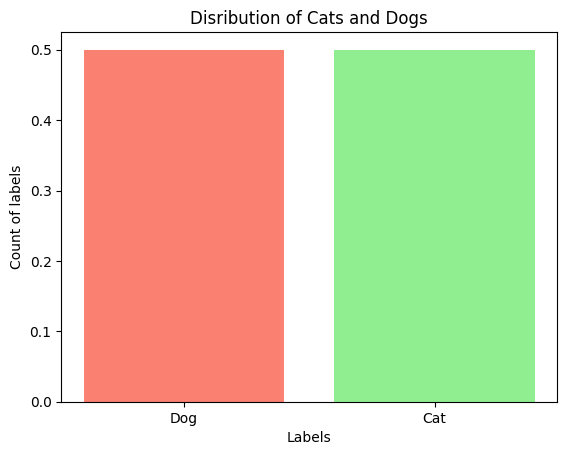

In [103]:
a = train_data['Label'].value_counts()
a = a/len(train_data['Label'])

plt.bar(a.index, a.values, color = ['salmon','lightgreen'])
plt.xlabel('Labels')
plt.ylabel('% of labels')
plt.title('Percentage disribution of Cats and Dogs')
plt.show()

In [82]:
train_df, val_df = train_test_split(train_data, test_size=0.2, random_state=42)

In [83]:
train_df.index

Index([23311, 23623,  1020, 12645,  1533,  3518,   483, 19370, 12667,  7403,
       ...
       16850,  6265, 22118, 11284, 11964, 21575,  5390,   860, 15795, 23654],
      dtype='int64', length=20000)

In [84]:
val_df.index

Index([ 6868, 24016,  9668, 13640, 14018,  7488,  5804, 12909,  3386,  9567,
       ...
        2315, 19003, 18389, 11917,  9136,  8670, 11839,  4013, 21147,   695],
      dtype='int64', length=5000)

In [86]:
train_df.reset_index(drop = True, inplace = True) #Resetting index of train dataframe

In [88]:
val_df.reset_index(drop = True, inplace = True) #Resetting index of validation dataframe

In [89]:
# Using ImageData Generator to augment image data for neural networks

# Creating an instance of ImageData Generator specifying parameters of augmentation

train_datagen = ImageDataGenerator(
    rotation_range=15,      # Random rotation within 15 degrees
    rescale=1./255,         # Rescaling factor for normalization of pixels
    zoom_range=0.2,         # Random zoom by 20%
    horizontal_flip=True,   # Random horizontal flipping
    width_shift_range=0.1,  # Random horizontal shift by 10%
    height_shift_range=0.1  # Random vertical shift by 10%
)

# Creating a generator to apply transformation to image data

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "../data/train/", 
    x_col='Filename',
    y_col='Label',
    class_mode='categorical',
    target_size=(224,224),
    batch_size=100
)

Found 20000 validated image filenames belonging to 2 classes.


In [90]:
# Using ImageData Generator to augment image data for neural networks

# Creating an instance of ImageData Generator specifying parameters of augmentation

val_datagen = ImageDataGenerator(rescale=1./255) # Rescaling factor for normalization of pixels

val_generator = val_datagen.flow_from_dataframe(
    val_df, 
    "../data/train/", 
    x_col='Filename',
    y_col='Label',
    class_mode='categorical',
    target_size=(224,224),
    batch_size=100
)

Found 5000 validated image filenames belonging to 2 classes.


In [91]:
# Using ImageData Generator to augment image data for neural networks

# Creating an instance of ImageData Generator specifying parameters of augmentation

test_datagen = ImageDataGenerator(rescale=1./255) # Rescaling factor for normalization of pixels

test_generator = test_datagen.flow_from_dataframe(
    test_data, 
    "../data/test/", 
    x_col='Filename',
    y_col=None,
    class_mode=None,
    target_size=(224,224),
    batch_size=100,
    shuffle = False
)

Found 12500 validated image filenames.


**VGG16**

In [92]:
from tensorflow.keras.callbacks import EarlyStopping

# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [93]:
# Build the classification model on top of the pre-trained base model
model_vgg16 = Sequential()
model_vgg16.add(base_model)
model_vgg16.add(GlobalAveragePooling2D())
model_vgg16.add(Dense(256, activation='relu'))
model_vgg16.add(Dropout(0.5))
model_vgg16.add(Dense(2, activation='softmax'))  # 2 classes: Cat and Dog

In [94]:
# Compile the model
model_vgg16.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model_vgg16.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_5  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 2)                 514       
                                                                 
Total params: 14846530 (56.64 MB)
Trainable params: 131842 (515.01 KB)
Non-trainable params: 14714688 (56.13 MB)
_______

In [95]:
# Set up EarlyStopping callback to stop training if the validation loss doesn't improve
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [96]:
# Train the model using the data generators
history = model_vgg16.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=5,
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size,
    callbacks=[early_stopping]
)

Epoch 1/5
200/200 [==============================] - 270s 1s/step - loss: 0.3966 - accuracy: 0.8170 - val_loss: 0.2392 - val_accuracy: 0.9006
Epoch 2/5
200/200 [==============================] - 268s 1s/step - loss: 0.2747 - accuracy: 0.8822 - val_loss: 0.2005 - val_accuracy: 0.9144
Epoch 3/5
200/200 [==============================] - 268s 1s/step - loss: 0.2514 - accuracy: 0.8927 - val_loss: 0.1868 - val_accuracy: 0.9192
Epoch 4/5
200/200 [==============================] - 268s 1s/step - loss: 0.2395 - accuracy: 0.8992 - val_loss: 0.1803 - val_accuracy: 0.9206
Epoch 5/5
200/200 [==============================] - 266s 1s/step - loss: 0.2270 - accuracy: 0.9067 - val_loss: 0.1968 - val_accuracy: 0.9194


In [97]:
# Evaluate the model on the test set
predict_vgg16 = model_vgg16.predict_generator(test_generator, steps=test_generator.n // test_generator.batch_size, verbose=1)

/tmp/ipykernel_47/3506741850.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict_vgg16 = model_vgg16.predict_generator(test_generator, steps=test_generator.n // test_generator.batch_size, verbose=1)


125/125 [==============================] - 54s 433ms/step


In [98]:
test_vgg16 = test_data

test_vgg16['label'] = list(predict_vgg16[:, 1])

In [99]:
test_vgg16['ID'] = test_vgg16['Filename'].apply(lambda x: int(x.replace('.jpg', '')))
test_vgg16 = test_vgg16.sort_values(by='ID')

In [100]:
test_data.head(10)

,Filename,label,ID
0,10435.jpg,0.000501,10435
1,6790.jpg,0.999972,6790
2,4644.jpg,0.210975,4644
3,1835.jpg,0.005468,1835
4,1102.jpg,0.001307,1102
5,8962.jpg,0.080620,8962
6,6040.jpg,0.837491,6040
7,4423.jpg,0.062935,4423
8,12072.jpg,0.578891,12072
9,1806.jpg,0.907292,1806


In [101]:
test_data[['ID', 'label']].to_csv('first_vgg16.csv', index = False)

**InceptionV3**

In [53]:
# Load the InceptionV3 model pre-trained on ImageNet data
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

In [54]:
# Create a new model on top of the pre-trained model
model_iv3 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(2, activation='softmax')  # 2 classes: Cat and Dog
])

In [55]:
# Compile the model
model_iv3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model_iv3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dense_5 (Dense)             (None, 2)                 514       
                                                                 
Total params: 22327842 (85.17 MB)
Trainable params: 525058 (2.00 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [56]:
# Train the model
history = model_iv3.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=5,
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size,
    callbacks=[early_stopping]
)

Epoch 1/5
200/200 [==============================] - 259s 1s/step - loss: 0.0724 - accuracy: 0.9739 - val_loss: 0.0578 - val_accuracy: 0.9810
Epoch 2/5
200/200 [==============================] - 253s 1s/step - loss: 0.0427 - accuracy: 0.9855 - val_loss: 0.0386 - val_accuracy: 0.9854
Epoch 3/5
200/200 [==============================] - 252s 1s/step - loss: 0.0433 - accuracy: 0.9839 - val_loss: 0.0416 - val_accuracy: 0.9842
Epoch 4/5
200/200 [==============================] - 252s 1s/step - loss: 0.0423 - accuracy: 0.9840 - val_loss: 0.0389 - val_accuracy: 0.9856
Epoch 5/5
200/200 [==============================] - 252s 1s/step - loss: 0.0367 - accuracy: 0.9860 - val_loss: 0.0433 - val_accuracy: 0.9856


In [57]:
# Evaluate the model on the test set
predict_iv3 = model_iv3.predict_generator(test_generator, steps=test_generator.n // test_generator.batch_size, verbose=1)

/tmp/ipykernel_47/1420846515.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict_iv3 = model_iv3.predict_generator(test_generator, steps=test_generator.n // test_generator.batch_size, verbose=1)


125/125 [==============================] - 34s 261ms/step


In [58]:
test_iv3 = test_data

test_iv3['label'] = list(predict_iv3[:, 1])

test_iv3['ID'] = test_iv3['Filename'].apply(lambda x: int(x.replace('.jpg', '')))
test_iv3 = test_iv3.sort_values(by='ID')

In [59]:
test_iv3.head(10)

,Filename,label,ID
9066,1.jpg,0.000006,1
11332,2.jpg,0.999647,2
5360,3.jpg,0.000313,3
12343,4.jpg,0.000219,4
10594,5.jpg,0.000021,5
9173,6.jpg,0.000653,6
3334,7.jpg,0.995152,7
4995,8.jpg,0.206457,8
6160,9.jpg,0.000537,9
7555,10.jpg,0.012062,10


In [60]:
test_iv3[['ID', 'label']].to_csv('second_iv3.csv', index = False)

***Resnet***

In [63]:
# Load the ResNet50 model pre-trained on ImageNet data
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [67]:
# Add a custom top layer for binary classification (cats vs dogs)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(2, activation='sigmoid')(x)

In [68]:
# Create the final model
model_resnet = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [69]:
# Train the model
history = model_resnet.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=5,
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size,
    callbacks=[early_stopping]
)

Epoch 1/5
200/200 [==============================] - 265s 1s/step - loss: 0.6848 - accuracy: 0.5767 - val_loss: 0.6528 - val_accuracy: 0.6024
Epoch 2/5
200/200 [==============================] - 259s 1s/step - loss: 0.6551 - accuracy: 0.6091 - val_loss: 0.6332 - val_accuracy: 0.6442
Epoch 3/5
200/200 [==============================] - 260s 1s/step - loss: 0.6467 - accuracy: 0.6237 - val_loss: 0.6403 - val_accuracy: 0.6214
Epoch 4/5
200/200 [==============================] - 260s 1s/step - loss: 0.6531 - accuracy: 0.6152 - val_loss: 0.6231 - val_accuracy: 0.6580
Epoch 5/5
200/200 [==============================] - 260s 1s/step - loss: 0.6442 - accuracy: 0.6226 - val_loss: 0.6233 - val_accuracy: 0.6522


In [70]:
# Evaluate the model on the test set
predict_resnet = model_resnet.predict_generator(test_generator, steps=test_generator.n // test_generator.batch_size, verbose=1)

/tmp/ipykernel_47/3360168994.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict_resnet = model_resnet.predict_generator(test_generator, steps=test_generator.n // test_generator.batch_size, verbose=1)


125/125 [==============================] - 41s 318ms/step


In [71]:
test_resnet = test_data

test_resnet['label'] = list(predict_resnet[:, 1])

test_resnet['ID'] = test_resnet['Filename'].apply(lambda x: int(x.replace('.jpg', '')))
test_resnet = test_resnet.sort_values(by='ID')

In [72]:
test_resnet[['ID', 'label']].to_csv('third_resnet.csv', index = False)